## Preambule

In [360]:
# General packages
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import xarray as xr
import json

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors

## Parameter

In [361]:
hist_startyear = 1990
rules = ['GF', 'PC', 'PCC', 'ECPC', 'AP', 'GDR']

## Paths

In [362]:
path_main = Path("X:/user/dekkerm/Projects/ECEMF_T5.2/")
path_data = path_main / "Data" / str(hist_startyear)
path_figs = path_main / "Figures"

## Read data files

In [363]:
xr_total = xr.open_dataset(path_data / "xr_total.nc")
all_regions_iso = np.load(path_data / "all_regions.npy")
all_regions_names = np.load(path_data / "all_regions_names.npy")
all_countries_iso = np.load(path_data / "all_countries.npy", allow_pickle=True)
all_countries_names = np.load(path_data / "all_countries_names.npy", allow_pickle=True)
only_regions_iso = ['CVF', 'G20', "EU", "G7", "NA", "AU", "AF", "SIDS", "LDC", "WORLD"]
only_regions_names = ['Climate Vulnerability Forum','G20',"European Union","G7","Northern America","Australasia","African Group","Small Island Developing States","Least Developed Countries"]

In [364]:
xr_budgets_static = xr.open_dataset(path_data / "xr_budgets_static.nc")
#xr_budgets_linear = xr.open_dataset(path_data / "xr_budgets_linear.nc")
xr_budgets_scenario = xr.open_dataset(path_data / "xr_budgets_scenario.nc")
df_michel = pd.read_excel(Path("X:/user/dekkerm/Data/") / "NDC" / "NDC_comparison.xlsx", sheet_name="Michel")

In [365]:
factor_lulucf = float(np.mean(xr_total.GHG_f_incl.sel(Time=2030)/xr_total.GHG_f.sel(Time=2030)))

In [366]:
df = pd.read_excel(Path("X:/user/dekkerm/Data/") / "UNFCCC_Parties_Groups_noeu.xlsx", sheet_name = "Country groups")
countries_iso = np.array(df["Country ISO Code"])
group_cvf = countries_iso[np.array(df["CVF (24/10/22)"]) == 1]
group_g20 = countries_iso[np.array(df["G20"]) == 1]
group_eu = countries_iso[np.array(df["EU"]) == 1]
group_g7 = countries_iso[np.array(df["G7"]) == 1]
group_na = countries_iso[np.array(df["Northern America"]) == 1]
group_um = countries_iso[np.array(df["Umbrella"]) == 1]
group_au = countries_iso[np.array(df["Australasia"]) == 1]
group_af = countries_iso[np.array(df["African Group"]) == 1]
group_sids = countries_iso[np.array(df["SIDS"]) == 1]
group_ldc = countries_iso[np.array(df["LDC"]) == 1]
group_eg = countries_iso[np.array(df["European Group"]) == 1]

In [367]:
df = pd.read_csv(Path("X:/user/dekkerm/Data/") / "AllCountries.csv")
cont_iso = np.array(df['alpha-3']).astype(str)
cont_reg = np.array(df['sub-region']).astype(str)
unireg = np.unique(cont_reg)[:-1]

## Derive relationship between cumulative GHG and temperature assessment

In [368]:
df_ar6_meta = pd.read_excel("X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx", sheet_name='meta_Ch3vetted_withclimate')
df_ar6_data = pd.read_csv("X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_World_v1.1.csv")

In [369]:
mods = np.array(df_ar6_meta.Model)
scens = np.array(df_ar6_meta.Scenario)
modscens_meta = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_meta['ModelScenario'] = modscens_meta
modcat = np.array([np.array(df_ar6_meta.ModelScenario), np.array(df_ar6_meta.Category)])
mods = np.array(df_ar6_data.Model)
scens = np.array(df_ar6_data.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
df_ar6_data['ModelScenario'] = modscens

In [370]:
df_ar6_new = df_ar6_data[df_ar6_data.Variable.isin(['Emissions|CO2',
                                                    'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile',
                                                    'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|5.0th Percentile',
                                                    'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|95.0th Percentile',
                                                    "Emissions|Kyoto Gases"
                                                    ])][['ModelScenario', 'Variable']+list(np.arange(2020, 2101).astype(str))]
df_ar6_new = df_ar6_new.reset_index(drop=True)
df_ar6_new = df_ar6_new.melt(id_vars = ["ModelScenario", 'Variable'], var_name='Time', value_name='Value')
df_ar6_new['Time'] = df_ar6_new['Time'].astype(int)
df_dummy = df_ar6_new.set_index(['ModelScenario', 'Variable', "Time"])
xr_ar6_new = xr.Dataset.from_dataframe(df_dummy)
xr_ar6_new = xr_ar6_new.reindex(Time = np.arange(2020, 2101))
xr_ar6_new = xr_ar6_new.interpolate_na(dim="Time", method="linear")

x:\user\dekkerm\environments\MyEnv\lib\site-packages\xarray\core\missing.py:264: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



In [371]:
modscens = np.array(xr_ar6_new.ModelScenario)
temperatures = np.array(xr_ar6_new.sel(Variable = "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile", Time=2100).Value)
temperatures5 = np.array(xr_ar6_new.sel(Variable = "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|5.0th Percentile", Time=2100).Value)
temperatures95 = np.array(xr_ar6_new.sel(Variable = "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|95.0th Percentile", Time=2100).Value)
ghg_2030 = np.array(xr_ar6_new.sel(Variable = "Emissions|Kyoto Gases", Time=2030).Value)

# Remove nans
nonans_temp = np.where(~np.isnan(temperatures))[0]
nonans_ghg = np.where(~np.isnan(ghg_2030))[0]
nonans = np.intersect1d(nonans_temp, nonans_ghg)
modscens = modscens[nonans]
temperatures = temperatures[nonans]
temperatures5 = temperatures5[nonans]
temperatures95 = temperatures95[nonans]
ghg_2030 = ghg_2030[nonans]

# Remove zeros
nozero_ghg = np.where(ghg_2030 > 0)[0]
modscens = modscens[nozero_ghg]
temperatures = temperatures[nozero_ghg]
temperatures5 = temperatures5[nozero_ghg]
temperatures95 = temperatures95[nozero_ghg]
ghg_2030 = ghg_2030[nozero_ghg]/factor_lulucf

# Linear regression
k = 3
coef_ghg_2030 = np.polyfit(ghg_2030, temperatures, k)

GF USA 0.12879119799959096
GF CHN 0.26628051970694333
GF EU 0.07716748222501402
PC USA 0.04148390624528287
PC CHN 0.16729675420899745
PC EU 0.05241650133458042
AP USA 0.09291677095756996
AP CHN 0.28303564148735444
AP EU 0.051766566905170903
GDR USA 0.043832697573339074
GDR CHN 0.33213054294648753
GDR EU 0.03683566890245404


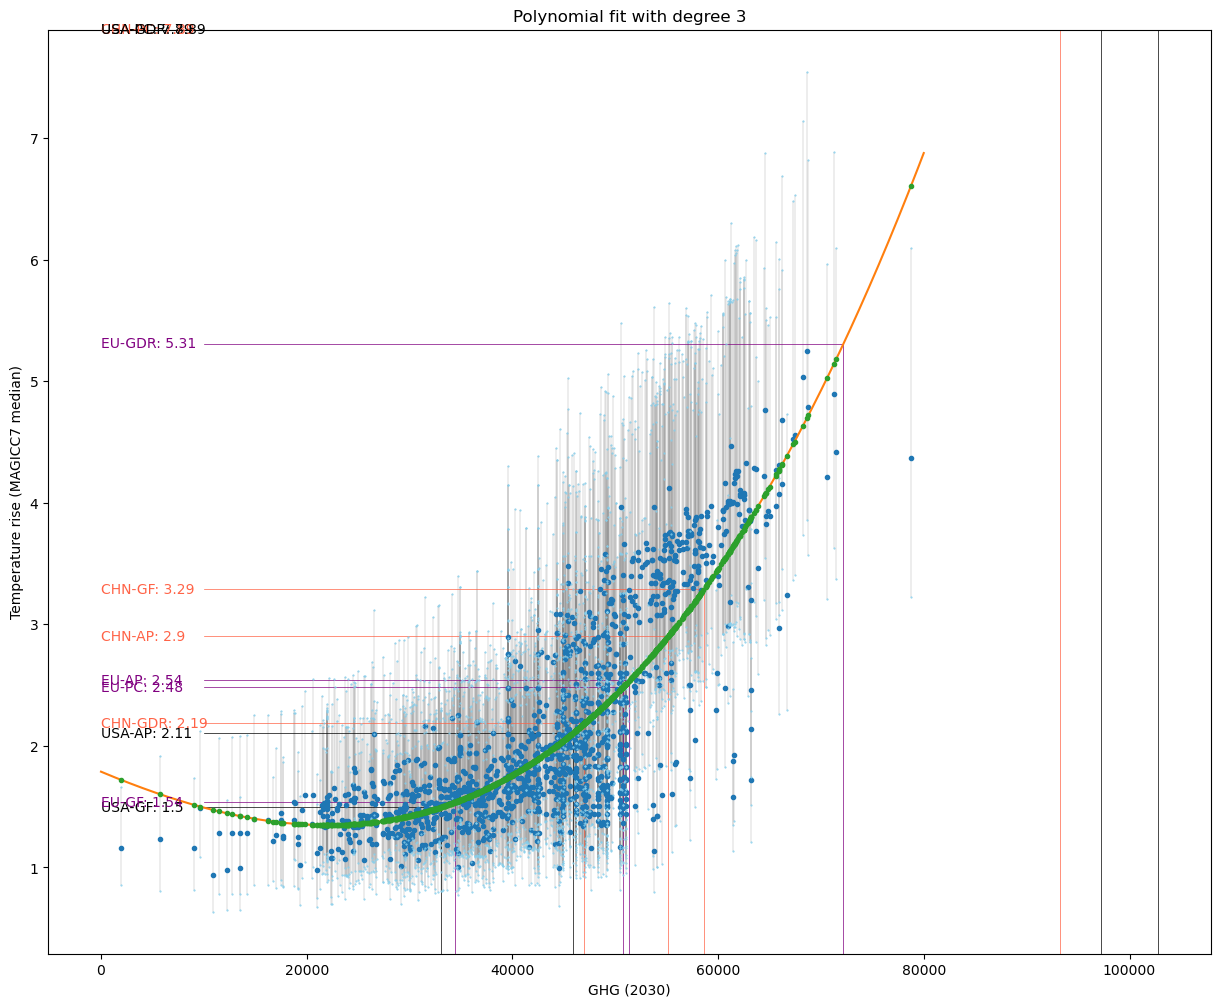

In [372]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(ghg_2030, temperatures, '.')
ax.plot(ghg_2030, temperatures5, '.', c='skyblue', ms=1)
ax.plot(ghg_2030, temperatures95, '.', c='skyblue', ms=1)
for i in range(len(ghg_2030)):
    ax.plot([ghg_2030[i], ghg_2030[i]], [temperatures5[i], temperatures95[i]], 'grey', lw=0.2, zorder=-1e9)
ax.set_ylim(ax.get_ylim())
ax.plot(np.arange(1, 80000., 10), np.sum([np.arange(1, 80000., 10)**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0), '-')
ax.plot(ghg_2030, np.sum([ghg_2030**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0), '.')
for var in ['GF', 'PC', 'AP', 'GDR']:
    for cty_i, cty in enumerate(['USA', 'CHN', 'EU']):
        perc = np.array(xr_budgets_scenario.sel(Time=2030, ISO=cty)[var] / xr_budgets_scenario.sel(Time=2030, ISO='WORLD')["GF"]).mean()
        print(var, cty, perc)
        ndc = float((xr_total.sel(ISO=cty, Time=2030).NDC_h+xr_total.sel(ISO=cty, Time=2030).NDC_l)/2)*1e3
        ndc_globalversion = ndc/perc
        inters = np.max([np.min([np.sum([ndc_globalversion**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0), ax.get_ylim()[1]]), ax.get_ylim()[0]])
        ax.plot([ndc_globalversion, ndc_globalversion], [-1e3, inters], c=['k', 'tomato', 'purple'][cty_i], lw=0.5, zorder=-1e9)
        ax.plot([10000, ndc_globalversion], [inters, inters], c=['k', 'tomato', 'purple'][cty_i], lw=0.5, zorder=-1e9)
        ax.text(0, inters , cty+'-'+var+': '+str(np.round(inters, 2)), ha='left', c=['k', 'tomato', 'purple'][cty_i], va='center', fontsize=10)
ax.set_ylabel("Temperature rise (MAGICC7 median)")
ax.set_xlabel("GHG (2030)")
ax.set_title("Polynomial fit with degree "+str(k))
plt.show()

In [373]:
temps = np.zeros(shape=(len(rules), len(all_countries_iso)))
for var_i, var in enumerate(rules):
    for cty_i, cty in enumerate(all_countries_iso):
        perc = np.array(xr_budgets_scenario.sel(Time=2030, ISO=cty)[var] / xr_budgets_scenario.sel(Time=2030, ISO='WORLD')["GF"]).mean()
        if perc < 0: perc = 1e-8
        ndc = float((xr_total.sel(ISO=cty, Time=2030).NDC_h+xr_total.sel(ISO=cty, Time=2030).NDC_l)/2)*1e3
        ndc_globalversion = ndc/perc
        if ndc_globalversion < 25000:
            if cty == 'USA':
                print(cty, ndc_globalversion, perc, ndc, var)
            temps[var_i, cty_i] = 1.345
        else:
            inters = np.sum([ndc_globalversion**n*coef_ghg_2030[k-n] for n in range(k+1)], axis=0)
            temps[var_i, cty_i] = inters

## Plot

In [374]:
rules

['GF', 'PC', 'PCC', 'ECPC', 'AP', 'GDR']

In [375]:
fig = make_subplots(rows=2, cols=3, #subplot_titles=('Grandfathering (GF)',
                                                    # 'Per Capita (PC)',
                                                    # 'Per Capita Convergence (PCC)',
                                                    # 'Equal Cumulative Per Capita',
                                                    # 'Ability to pay (AP)',
                                                    # 'Greenhouse Development Rights'), 
                                    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}]],
                                    horizontal_spacing = 0,
                                    vertical_spacing=0)

colorbar_abs = dict(len=1, x=1, tickvals = [0, 1, 2, 3], ticktext = ['1', '10', '100', '1000'])
colorbar_pc = dict(len=1, x=1)

for var_i, var in enumerate(rules):
    if var_i == 0:
        cm= True
    else:
        cm= False
    fig.add_trace(
        go.Choropleth(
        locations=group_eu,
        z = xr_budgets_static.sel(Category="C1+C2", ISO=group_eu)[var],
        locationmode = 'ISO-3',
        colorscale = 'matter',
        zmax = 25,
        zmin = 0,
        text = [str(r)+": "+str(np.round(float(xr_budgets_static.sel(Category="C1+C2", ISO=r)[var]), 2))+" Gt CO2e" for r_i, r in enumerate(group_eu)],
        hovertemplate  = '%{text}',
        name="",
        marker_line_color='white', 
        marker_line_width=0.2,
        colorbar=dict(len=1, x=1, tickvals = np.arange(0, 25+0.1, 5), title={"text":"GHG budget<br>2020-2100<br>(Gt CO2e)"}, tickfont={'size': 25}),
        showscale=cm
    ), [1, 1, 1, 2, 2, 2][var_i], [1, 2, 3, 1, 2, 3][var_i])
# fig.update_geos(showocean=True, oceancolor="white")
# fig.update_geos(showlakes=True, lakecolor="white")

# limite map scope to USA 'africa', 'asia', 'europe', 'north america', 'south america', 'usa', 'world'
fig.update_layout(
    geo1 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo2 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo3 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo4 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo5 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo6 = dict(scope='europe', 
                showlakes=False,
                showcoastlines=False,),
)

#vals = xr_budgets_static.sel(Category="C1+C2", ISO=group_eu)[rules]
#vals[vals]
mn = np.min(np.array([float(xr_budgets_static.sel(Category="C1+C2", ISO=group_eu)[rules].min()[r]) for r in rules]))
mx = np.max(np.array([float(xr_budgets_static.sel(Category="C1+C2", ISO=group_eu)[rules].max()[r]) for r in rules]))
for var_i, var in enumerate(rules):
    vals = np.array(xr_budgets_static.sel(Category="C1+C2", ISO=group_eu)[var])
    vals_i = (vals + mn)**1.2
    vals_n = 14*(vals - mn)/(mx - mn)+7
    vals_boolean = np.copy(vals)
    vals_boolean[vals >= 0] = 1
    vals_boolean[vals < 0] = 0
    vals_boolean = vals_boolean.astype(int)
    
    fig.add_scattergeo(
                locations = group_eu,
                text = vals.round(1),
                featureidkey="properties.NAME_3",
                mode = 'text',
                hoverinfo='skip',
                showlegend=False,
                textfont={'size': vals_n,
                          'color': np.array(['darkred', 'black'])[vals_boolean]},
                row=[1, 1, 1, 2, 2, 2][var_i],
                col=[1, 2, 3, 1, 2, 3][var_i])

fig.update_geos(visible=False,
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                projection_type='natural earth',
                resolution=50,
                lataxis_range=[30,75], lonaxis_range=[-20, 40],
                showcoastlines=False,)

#fig.update_traces(showscale=False)
fig.update_layout(height=1200, width=2300)
fig.update_geos(visible=True, showcountries=False)#fitbounds="locations",
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.96, x=0.07, text="<b>(a) Grandfathering</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.96, x=0.47, text="<b>(b) Per Capita</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.96, x=0.90, text="<b>(c) Per Capita Convergence</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.45, x=0.07, text="<b>(d) Equal Cumulative per Capita</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.45, x=0.48, text="<b>(e) Ability to Pay</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.45, x=0.95, text="<b>(f) Greenhouse Development Rights</b>")
fig_europe = fig
fig.show()

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_3352\165106681.py:72: RuntimeWarning:

invalid value encountered in power

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_3352\165106681.py:72: RuntimeWarning:

invalid value encountered in power

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_3352\165106681.py:72: RuntimeWarning:

invalid value encountered in power

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_3352\165106681.py:72: RuntimeWarning:

invalid value encountered in power

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_3352\165106681.py:72: RuntimeWarning:

invalid value encountered in power

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_3352\165106681.py:72: RuntimeWarning:

invalid value encountered in power



In [376]:
fig_europe.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_budgets.svg")
fig_europe.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_budgets.png", scale=3)

import os
from datetime import date
try:
    os.remove('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_budgets.html')
except:
    3
def html_w(typ):
    return '<html> '+typ+' <p style="font-family: Arial">'

today = date.today()
td = today.strftime("%B %d, %Y")

with open('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_budgets.html', 'a') as f:
    #f.write(html_w('<h1>')+'Figure 1 - Electricity Generation</p></h1>')
    f.write(html_w('<body>')+'Version: '+td+'</p></body>')
    f.write(fig_europe.to_html(full_html=False, include_plotlyjs='cdn'))

## Figure relative

In [377]:
fig = make_subplots(rows=2, cols=3, #subplot_titles=('Grandfathering (GF)',
                                                    # 'Per Capita (PC)',
                                                    # 'Per Capita Convergence (PCC)',
                                                    # 'Equal Cumulative Per Capita',
                                                    # 'Ability to pay (AP)',
                                                    # 'Greenhouse Development Rights'), 
                                    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}]],
                                    horizontal_spacing = 0,
                                    vertical_spacing=0)

colorbar_abs = dict(len=1, x=1, tickvals = [0, 1, 2, 3], ticktext = ['1', '10', '100', '1000'])
colorbar_pc = dict(len=1, x=1)

for var_i, var in enumerate(rules):
    if var_i == 0:
        cm= True
    else:
        cm= False
    fig.add_trace(
        go.Choropleth(
        locations=group_eu,
        z = xr_budgets_static.sel(Category="C1+C2", ISO=group_eu)[var] / xr_total.GHG_p.sel(Time=2019, ISO=group_eu),
        locationmode = 'ISO-3',
        colorscale = 'RdBu',
        zmax = 40,
        zmin = -40,
        text = [str(r)+": "+str(np.round(float(xr_budgets_static.sel(Category="C1+C2", ISO=r)[var] / xr_total.GHG_p.sel(Time=2019, ISO=r)), 2))+" times" for r_i, r in enumerate(group_eu)],
        hovertemplate  = '%{text}',
        name="",
        marker_line_color='white', 
        marker_line_width=0.2,
        colorbar=dict(len=1, x=1, tickvals = np.arange(-40, 40+0.1, 5), title={"text":"GHG budget<br>2020-2100<br>relative<br>to 2019"}, tickfont={'size': 25}),
        showscale=cm
    ), [1, 1, 1, 2, 2, 2][var_i], [1, 2, 3, 1, 2, 3][var_i])
# fig.update_geos(showocean=True, oceancolor="white")
# fig.update_geos(showlakes=True, lakecolor="white")

# limite map scope to USA 'africa', 'asia', 'europe', 'north america', 'south america', 'usa', 'world'
fig.update_layout(
    geo1 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo2 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo3 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo4 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo5 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo6 = dict(scope='europe', 
                showlakes=False,
                showcoastlines=False,),
)

#vals = xr_budgets_static.sel(Category="C1+C2", ISO=group_eu)[rules]
#vals[vals]
mn = np.min(np.array([float((xr_budgets_static.sel(Category="C1+C2", ISO=group_eu)[rules] / xr_total.GHG_p.sel(Time=2019, ISO=group_eu)).min()[r]) for r in rules]))
mx = np.max(np.array([float((xr_budgets_static.sel(Category="C1+C2", ISO=group_eu)[rules] / xr_total.GHG_p.sel(Time=2019, ISO=group_eu)).max()[r]) for r in rules]))
for var_i, var in enumerate(rules):
    vals = np.array(xr_budgets_static.sel(Category="C1+C2", ISO=group_eu)[var] / xr_total.GHG_p.sel(Time=2019, ISO=group_eu))
    vals_i = (vals + mn)**1.2
    vals_n = 14*(vals - mn)/(mx - mn)+7
    vals_boolean = np.copy(vals)
    vals_boolean[vals >= 0] = 1
    vals_boolean[vals < 0] = 0
    vals_boolean = vals_boolean.astype(int)
    
    fig.add_scattergeo(
                locations = group_eu,
                text = vals.round(1),
                featureidkey="properties.NAME_3",
                mode = 'text',
                hoverinfo='skip',
                showlegend=False,
                textfont={'size': vals_n,
                          'color': np.array(['darkred', 'black'])[vals_boolean]},
                row=[1, 1, 1, 2, 2, 2][var_i],
                col=[1, 2, 3, 1, 2, 3][var_i])

fig.update_geos(visible=False,
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                projection_type='natural earth',
                resolution=50,
                lataxis_range=[30,75], lonaxis_range=[-20, 40],
                showcoastlines=False,)

#fig.update_traces(showscale=False)
fig.update_layout(height=1200, width=2300)
fig.update_geos(visible=True, showcountries=False)#fitbounds="locations", 
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.96, x=0.07, text="<b>(a) Grandfathering</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.96, x=0.47, text="<b>(b) Per Capita</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.96, x=0.90, text="<b>(c) Per Capita Convergence</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.45, x=0.07, text="<b>(d) Equal Cumulative per Capita</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.45, x=0.48, text="<b>(e) Ability to Pay</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.45, x=0.95, text="<b>(f) Greenhouse Development Rights</b>")
fig_europe = fig
fig.show()
fig_ndc_rel = fig

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_3352\4251735587.py:72: RuntimeWarning:

invalid value encountered in power

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_3352\4251735587.py:72: RuntimeWarning:

invalid value encountered in power

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_3352\4251735587.py:72: RuntimeWarning:

invalid value encountered in power

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_3352\4251735587.py:72: RuntimeWarning:

invalid value encountered in power

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_3352\4251735587.py:72: RuntimeWarning:

invalid value encountered in power

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_3352\4251735587.py:72: RuntimeWarning:

invalid value encountered in power



In [378]:
fig_ndc_rel.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_budgets_rel.svg")
fig_ndc_rel.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_budgets_rel.png", scale=3)

import os
from datetime import date
try:
    os.remove('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_budgets_rel.html')
except:
    3
def html_w(typ):
    return '<html> '+typ+' <p style="font-family: Arial">'

today = date.today()
td = today.strftime("%B %d, %Y")

with open('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_budgets_rel.html', 'a') as f:
    #f.write(html_w('<h1>')+'Figure 1 - Electricity Generation</p></h1>')
    f.write(html_w('<body>')+'Version: '+td+'</p></body>')
    f.write(fig_ndc_rel.to_html(full_html=False, include_plotlyjs='cdn'))

## NDC picture

In [379]:
fig = make_subplots(rows=1, cols=1, #subplot_titles=('Grandfathering (GF)',
                                                    # 'Per Capita (PC)',
                                                    # 'Per Capita Convergence (PCC)',
                                                    # 'Equal Cumulative Per Capita',
                                                    # 'Ability to pay (AP)',
                                                    # 'Greenhouse Development Rights'), 
                                    specs=[[{'type': 'choropleth'}]],
                                    horizontal_spacing = 0,
                                    vertical_spacing=0)

ndc = (xr_total.NDC_h.sel(ISO=group_eu, Time=2030)+xr_total.NDC_l.sel(ISO=group_eu, Time=2030))/2
ghg1990 = xr_total.GHG_p.sel(Time=1990, ISO=group_eu)
ndc_red = (ghg1990 - ndc) / ghg1990 * 100

for var_i, var in enumerate(rules):
    if var_i == 0:
        cm= True
    else:
        cm= False
    fig.add_trace(
        go.Choropleth(
        locations=group_eu,
        z = ndc_red,
        locationmode = 'ISO-3',
        colorscale = 'deep',
        # zmax = 50,
        # zmin = 0,
        text = [str(r)+": "+str(np.round(float(ndc_red.sel(ISO=r)), 2))+" %" for r_i, r in enumerate(group_eu)],
        hovertemplate  = '%{text}',
        name="",
        marker_line_color='white', 
        marker_line_width=0.2,
        colorbar=dict(len=1, x=1, tickvals = np.arange(0, 66, 5), ticktext=[str(p)+'%' for p in np.arange(0, 66, 5)], title={"text":"GHG<br>reduction<br>relative<br>to 1990"}, tickfont={'size': 25}),#
        showscale=cm
    ), 1, 1)

# limite map scope to USA 'africa', 'asia', 'europe', 'north america', 'south america', 'usa', 'world'
fig.update_layout(
    geo1 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
)

mn = float(np.min(ndc_red))
mx = float(np.max(ndc_red))
vals = np.array(ndc_red)
vals_i = (vals)**1.2
vals_n = 14*(vals - mn)/(mx - mn)+12
vals_boolean = np.copy(vals)
vals_boolean[vals >= 0] = 1
vals_boolean[vals < 0] = 0
vals_boolean = vals_boolean.astype(int)

fig.add_scattergeo(
            locations = group_eu,
            text = [str(v)+'%' for v in vals.astype(int)],
            featureidkey="properties.NAME_3",
            mode = 'text',
            hoverinfo='skip',
            showlegend=False,
            textfont={'size': vals_n,
                        'color': np.array(['darkred', 'black'])[vals_boolean]},
            row=1,
            col=1)

fig.update_geos(visible=False,
                showlakes=True,
                resolution=50,
                lataxis_range=[30,75], lonaxis_range=[-20, 40],
                lakecolor='rgb(255, 255, 255)',
                projection_type='natural earth',
                #center=dict(lon=-35, lat=-30),
                showcoastlines=False,)

#fig.update_traces(showscale=False)
fig.update_layout(height=800, width=1200)
fig.update_geos(visible=True, showcountries=False)#fitbounds="locations", 
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=30),
                   y=0.98, x=0.5, text="<b>NDC pledged GHG reduction w.r.t. 1990</b>")
fig_europe = fig
fig.show()
fig_ndc = fig

In [380]:
fig_ndc.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_ndc.svg")
fig_ndc.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_ndc.png", scale=3)

import os
from datetime import date
try:
    os.remove('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_ndc.html')
except:
    3
def html_w(typ):
    return '<html> '+typ+' <p style="font-family: Arial">'

today = date.today()
td = today.strftime("%B %d, %Y")

with open('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_ndc.html', 'a') as f:
    #f.write(html_w('<h1>')+'Figure 1 - Electricity Generation</p></h1>')
    f.write(html_w('<body>')+'Version: '+td+'</p></body>')
    f.write(fig_ndc.to_html(full_html=False, include_plotlyjs='cdn'))

## Temperature alignment

In [381]:
wh_eu = np.array([np.where(all_regions_iso == r)[0][0] for r in group_eu])

In [382]:
fig = make_subplots(rows=2, cols=3, #subplot_titles=('Grandfathering (GF)',
                                                    # 'Per Capita (PC)',
                                                    # 'Per Capita Convergence (PCC)',
                                                    # 'Equal Cumulative Per Capita',
                                                    # 'Ability to pay (AP)',
                                                    # 'Greenhouse Development Rights'), 
                                    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}]],
                                    horizontal_spacing = 0,
                                    vertical_spacing=0)

colorbar_abs = dict(len=1, x=1, tickvals = [0, 1, 2, 3], ticktext = ['1', '10', '100', '1000'])
colorbar_pc = dict(len=1, x=1)

temps2 = np.copy(temps)#.astype(str)
temps2[temps > 4] = 4
temps2[temps < 1.2] = 1.2

for var_i, var in enumerate(rules):
    if var_i == 0:
        cm= True
    else:
        cm= False
    fig.add_trace(
        go.Choropleth(
        locations=group_eu,
        z = temps[var_i][wh_eu],#xr_budgets_static.sel(Category="C1+C2", ISO=group_eu)[var],
        locationmode = 'ISO-3',
        colorscale = 'RdYlGn_r',
        zmax = 4,
        zmin = 1.5,
        text = [str(r)+": "+str(np.round(float(temps[var_i][wh_eu[r_i]]), 2))+" C" for r_i, r in enumerate(group_eu)],
        hovertemplate  = '%{text}',
        name="",
        marker_line_color='white', 
        marker_line_width=0.2,
        colorbar=dict(len=1, x=1, tickvals = np.arange(1.5, 4.1, 0.25), title={"text":"Temperature<br>rise<br>associated<br>with NDC"}, tickfont={'size': 25}),
        showscale=cm
    ), [1, 1, 1, 2, 2, 2][var_i], [1, 2, 3, 1, 2, 3][var_i])
# fig.update_geos(showocean=True, oceancolor="white")
# fig.update_geos(showlakes=True, lakecolor="white")

# limite map scope to USA 'africa', 'asia', 'europe', 'north america', 'south america', 'usa', 'world'
fig.update_layout(
    geo1 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo2 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo3 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo4 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo5 = dict(scope='europe', 
                showlakes=False,
                lakecolor='rgb(255, 255, 255)',
                showcoastlines=False,),
    geo6 = dict(scope='europe', 
                showlakes=False,
                showcoastlines=False,),
)

mn = np.min(temps2[:, wh_eu])#.min()[r]) for r in rules]))
mx = np.max(temps2[:, wh_eu])#np.max(np.array([float(xr_budgets_static.sel(Category="C1+C2", ISO=group_eu)[rules].max()[r]) for r in rules]))
for var_i, var in enumerate(rules):
    vals = np.copy(temps2[var_i][wh_eu])
    vals_i = (vals + mn)**0.5
    vals_n = 14*(vals - mn)/(mx - mn)+10
    vals_boolean = np.copy(vals)
    vals_boolean[vals >= 0] = 1
    vals_boolean[vals < 0] = 0
    vals_boolean = vals_boolean.astype(int)
    
    fig.add_scattergeo(
                locations = group_eu,
                text = vals.round(1),
                featureidkey="properties.NAME_3",
                mode = 'text',
                hoverinfo='skip',
                showlegend=False,
                textfont={'size': vals_n,
                          'color': np.array(['darkred', 'black'])[vals_boolean]},
                row=[1, 1, 1, 2, 2, 2][var_i],
                col=[1, 2, 3, 1, 2, 3][var_i])

fig.update_geos(visible=False,
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                projection_type='natural earth',
                resolution=50,
                lataxis_range=[30,75], lonaxis_range=[-20, 40],
                showcoastlines=False,)

#fig.update_traces(showscale=False)
fig.update_layout(height=1200, width=2300)
fig.update_geos(visible=True, showcountries=False)#fitbounds="locations",
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.96, x=0.07, text="<b>(a) Grandfathering</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.96, x=0.47, text="<b>(b) Per Capita</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.96, x=0.90, text="<b>(c) Per Capita Convergence</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.45, x=0.07, text="<b>(d) Equal Cumulative per Capita</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.45, x=0.48, text="<b>(e) Ability to Pay</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=25),
                   y=0.45, x=0.95, text="<b>(f) Greenhouse Development Rights</b>")
fig_talign = fig
fig.show()

In [383]:
fig_talign.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_temp.svg")
fig_talign.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_temp.png", scale=3)

import os
from datetime import date
try:
    os.remove('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_temp.html')
except:
    3
def html_w(typ):
    return '<html> '+typ+' <p style="font-family: Arial">'

today = date.today()
td = today.strftime("%B %d, %Y")

with open('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_Europe/Figure_europe_temp.html', 'a') as f:
    #f.write(html_w('<h1>')+'Figure 1 - Electricity Generation</p></h1>')
    f.write(html_w('<body>')+'Version: '+td+'</p></body>')
    f.write(fig_talign.to_html(full_html=False, include_plotlyjs='cdn'))

In [384]:
fig = make_subplots(rows=3, cols=3, #subplot_titles=('Grandfathering (GF)', 'Per Capita (PC)', 'Per Capita Convergence (PCC)', 'Bretschger (BR)', 'Ability to pay (AP)', 'Greenhouse Development Rights (GDR)'), 
                                                    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}],
                                                           [{'colspan': 3}, {}, {}]],
                                                    horizontal_spacing = 0, vertical_spacing=0.0)

colorbar_abs = dict(len=1, x=1, tickvals = [0, 1, 2, 3], ticktext = ['1', '10', '100', '1000'])
colorbar_pc = dict(len=1, x=1)

for var_i, var in enumerate(rules):
    if var_i == 0:
        cm= True
    else:
        cm= False
    wh = np.array([np.where(all_regions_iso == r)[0][0] for r in all_countries_iso])
    t = np.copy(temps[var_i][wh])
    #t[t >= 4] = np.nan
    fig.add_trace(
        go.Choropleth(
        locations=all_countries_iso,
        z = t,
        locationmode = 'ISO-3',
        colorscale = 'RdYlGn_r',
        zmax = 4,
        zmin = 1.5,
        text = [str(r)+": "+str(np.round(float(t[r_i]), 2))+" C" for r_i, r in enumerate(all_countries_iso)],
        hovertemplate  = '%{text}',
        name="",
        marker_line_color='black', 
        marker_line_width=0.3,
        colorbar=dict(len=1, x=1, tickvals = np.arange(1.5, 4, 0.25), title={"text":"Temperature<br>rise<br>associated<br>with NDC", 'font': {'size':17}}),
        showscale=cm
    ), [1, 1, 1, 2, 2, 2][var_i], [1, 2, 3, 1, 2, 3][var_i])
fig.update_geos(showocean=True, oceancolor="aliceblue")
fig.update_geos(showlakes=True, lakecolor="aliceblue")

# limite map scope to USA 'africa', 'asia', 'europe', 'north america', 'south america', 'usa', 'world'
fig.update_geos(visible=True,
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                projection_type='natural earth',
                showcoastlines=True,)

fig.add_trace(go.Scatter(x=cty_sort,
                        y=[0]*len(cty_sort),
                        name='',
                        line={'color': 'silver', 'width': 0.7},
                        mode='lines',
                        showlegend=False), 3, 1)
for cty_i, cty in enumerate(cty_sort):
    fig.add_trace(go.Scatter(x=[cty, cty],
                            y=[0, ndc_sort_h[cty_i]],
                            mode='lines',
                            line={'color': cols[cty_i], 'width': 0.7},
                            showlegend=False), 3, 1)
for i in range(4):    
    fig.add_trace(go.Scatter(x=['COD'],
                            y=[-10],
                            name=['Latin America', 'Africa', 'Europe, North America and Australia', 'Asia'][i],
                            textfont = {'size': 10, 'family': "Arial black", "color": cols},#, "size": 13, "color": "black"},
                            mode='text+markers',
                            marker={'color': ['forestgreen', 'tomato', 'steelblue', 'goldenrod'][i], 'size': 9, 'symbol': 'square'},
                            showlegend=True), 3, 1)
fig.add_trace(go.Scatter(x=cty_sort,
                         y=ndc_sort_h,
                         text=cty_sort_omit,
                         textfont = {'size': 10, 'family': "Arial black", "color": cols},#, "size": 13, "color": "black"},
                         mode='text+markers',
                         marker={'color': cols, 'size': 9, 'symbol': 'square'},
                         textposition=textpos,
                         showlegend=False), 3, 1)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.29,
    xanchor="left",
    x=0.08,
    font=dict(
        #family="Courier",
        size=15,
        color="black"
    ),
))

fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=1.01, x=0.07, text="<b>(a) Grandfathering</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=1.01, x=0.47, text="<b>(b) Per Capita</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=1.01, x=0.90, text="<b>(c) Per Capita Convergence</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=0.675, x=0.07, text="<b>(d) Equal Cumulative per Capita</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=0.675, x=0.48, text="<b>(e) Ability to Pay</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=0.675, x=0.95, text="<b>(f) Greenhouse Development Rights</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='left', ay=-0, showarrow=False, font=dict(color='black', size=18),
                   y=0.29, x=0.07, text="<b>(g) Ambition level of NDCs</b>")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='center', ay=-0, showarrow=False, textangle=-90, font=dict(color='black', size=12),
                    y=0.175, x=0.02, text=">>> More ambition")
fig.add_annotation(xref='paper', yref='paper',ax=0, align='center', ay=-0, showarrow=False, textangle=-90, font=dict(color='black', size=12),
                    y=0.02, x=0.02, text="Less ambition <<<")

#fig.update_traces(showscale=False)
fig.update_layout(height=1300*0.8,
                  width=2000*0.8,
                  template='simple_white',
                  xaxis = go.XAxis(title='Country', showticklabels=False),
                  yaxis = go.YAxis(title='GHG emission reduction in 2030 w.r.t. 2019', 
                                    range=(-1, 1),
                                    tickmode = 'array',
                                    tickvals = [-1, -0.75, -0.50, -0.25, 0, 0.25, 0.5, 0.75, 1],
                                    ticktext = ['+100%', '+75%', '+50%', '+25%', '0%', '-25%', '-50%', '-75%', '100%']))
#fig.update_traces(textposition='top')#list(position_dict.values()))
fig.update_xaxes(visible=False)
fig.show()

x:\user\dekkerm\environments\MyEnv\lib\site-packages\plotly\graph_objs\_deprecations.py:544: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


x:\user\dekkerm\environments\MyEnv\lib\site-packages\plotly\graph_objs\_deprecations.py:572: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




In [385]:
fig.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign.svg")
fig.write_image("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign.png", scale=3)

import os
from datetime import date
try:
    os.remove('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign.html')
except:
    3
def html_w(typ):
    return '<html> '+typ+' <p style="font-family: Arial">'

today = date.today()
td = today.strftime("%B %d, %Y")

with open('X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/Figure_tempalign/Figure_tempalign.html', 'a') as f:
    #f.write(html_w('<h1>')+'Figure 1 - Electricity Generation</p></h1>')
    f.write(html_w('<body>')+'Version: '+td+'</p></body>')
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))